In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from salishsea_tools import viz_tools
import sys
# from scipy import signal

In [47]:
sys.path.insert(1, '../../../../MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import river_202108 as rivers
# import river_202101 as rivers

#### 1. Load in the data and plot 6 days from throughout the dataset

In [3]:
# open dataset - should be day-averaged
physics_201905 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_1d_salinity_20190101_20191231.nc')
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')

In [5]:
def pre_process(physics,model):
        ## PRE-PROCESSING PART
    phys_arr = physics.vosaline.to_numpy()

    # make the indicies for plotting six sample salinity fields
    plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
    plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

    # open the mesh mask and use it to mask the land
    mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
    # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
    tmask = 1 - mesh.tmask[0]

    kd = 0 ## this will stay for surface
    imin = 0
    imax = 898
    jmin = 0
    jmax = 398
    dm = physics

    fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))


    ## SHOWS SALINITY PLOTS
    for i in np.arange(0,6):
        
        cmap = cm.haline
        cmap.set_bad('gray')

        
        day = plot_day[i]
        day_str = np.datetime_as_string(physics.time[day].values, unit='D')
        # salinity plot
        myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
        salinity = np.ma.masked_array(myarray, mask=tmask[0])
        colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
        ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
        cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
        cb.set_label('Salinity (g/kg)')
        viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
        
        
    fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg) ' + model)
    # plt.savefig('2020_samplesal.png')

    return(phys_arr)

In [6]:
def do_pca(phys_arr,model):
    
    # define dimensions for later reshaping
    num_days = phys_arr.shape[0]

    Nx = phys_arr.shape[2]
    Ny = phys_arr.shape[3]

    ## DO PCA PART
    surface = phys_arr[:,0,:,:].reshape(num_days, 357404)  # TODO: FIX THIS to not hard coded
    surface = np.nan_to_num(surface)

    # does the PCA part
    n_modes = np.min(np.shape(surface))
    pca = PCA(n_components = n_modes)
    PCs = pca.fit_transform(surface)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_

    #plot fraction of variance explained by each mode
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by All Modes ' + model, fontsize = 24)

    plt.subplot(1,2,2)
    n_modes_show = 10  # TODO change this to fun input
    plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

    plt.tight_layout()

    # if saveIt:
    #     plt.savefig('tutorial4_fig3.png')

    plt.show()

    return(pca, surface, Nx, Ny)

In [7]:
def show_pca(pca,surface,Nx,Ny,n,model):

    ## access the PCA results
    fracVar = pca.explained_variance_ratio_
    eigvecs = pca.components_
    PCs = pca.fit_transform(surface)

    np.sum(fracVar[:n]) # fraction of variance explained by this many modes  #TODO change this also to fn input, is the same n as below

    # make a mask of land where land is true and water in NaN
    # bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
    bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_202108.nc')
    land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
    land[land == 0] = np.nan

    # open the mesh mask and use it to mask the land
    # mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
    mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
    # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
    tmask = 1 - mesh.tmask[0]

    #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure

    fig2, ax2 = plt.subplots(n, 2, figsize=(25, 5*n))
    plt.suptitle(model)

    for kk in range(n):
        
        plt.subplot(n,2,kk*2+1)
        to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
        cb = ax2[kk,0].imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
        plt.colorbar(cb)
        cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
        viz_tools.set_aspect(ax2[kk,0]);
        
        
        ax2[kk,1].plot(PCs[:,kk], linewidth = 0.5)
        ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
        ax2[kk,1].set_xlabel('Day', fontsize = 20)
        
    plt.tight_layout()

    # plt.savefig('2020_modes.png')
    plt.show()

    return(fracVar,eigvecs,PCs)

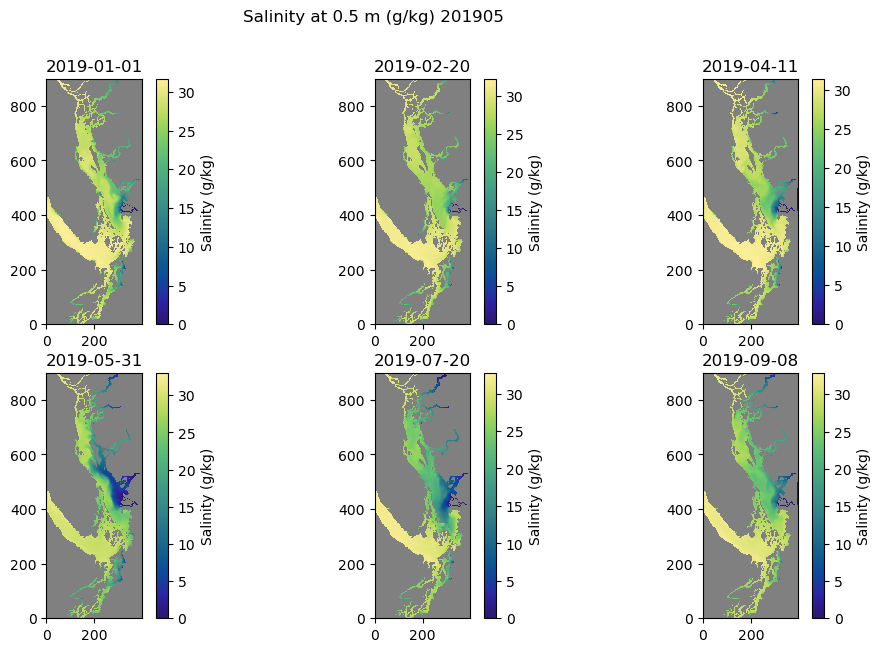

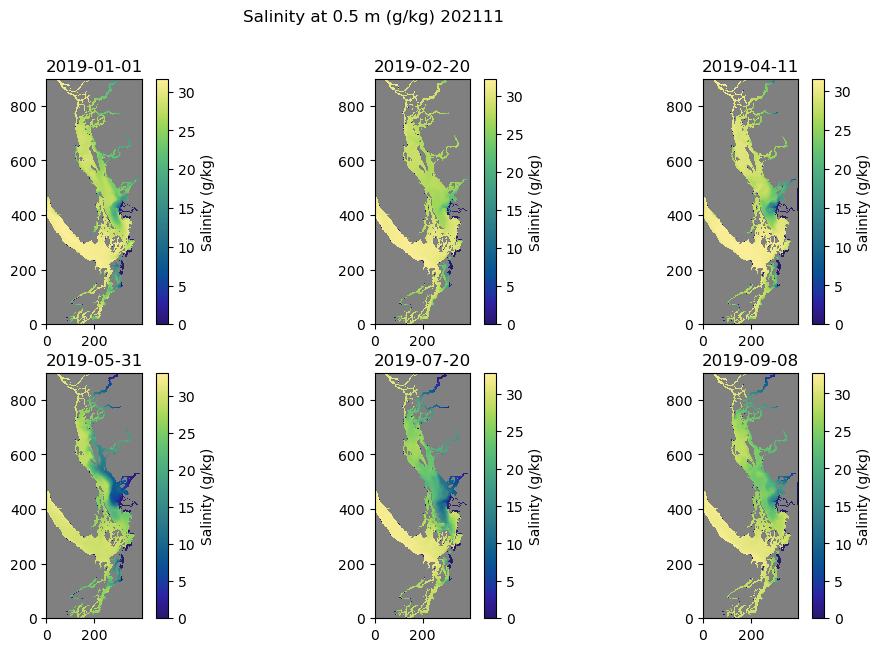

In [8]:
phys_arr_201905 = pre_process(physics_201905,'201905')
phys_arr_202111 = pre_process(physics_202111,'202111')

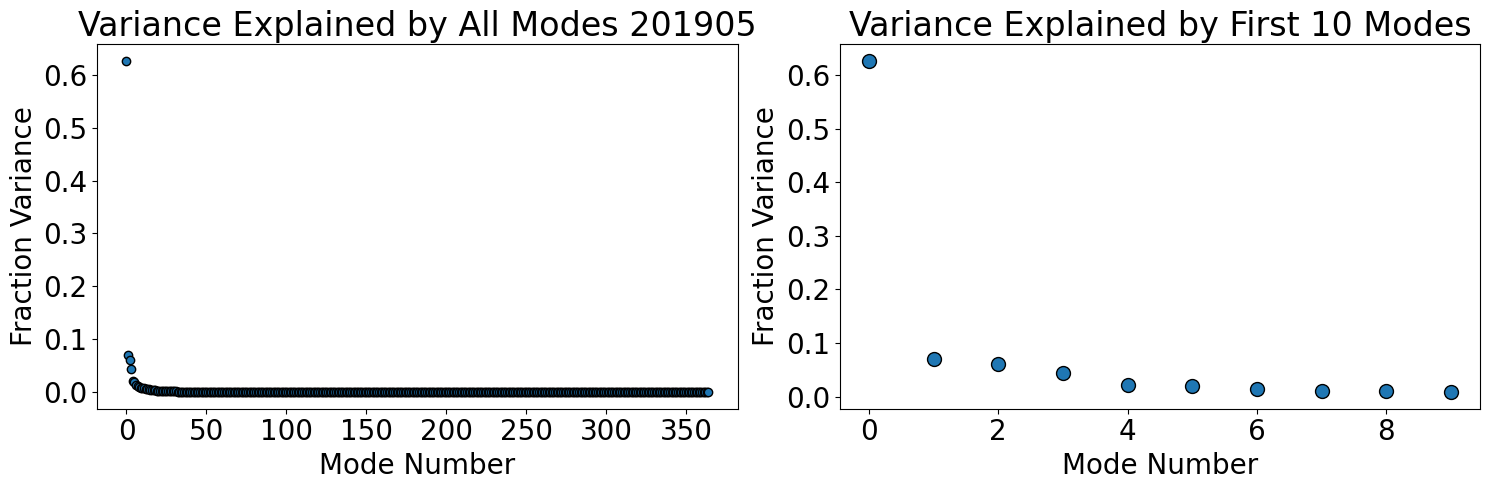

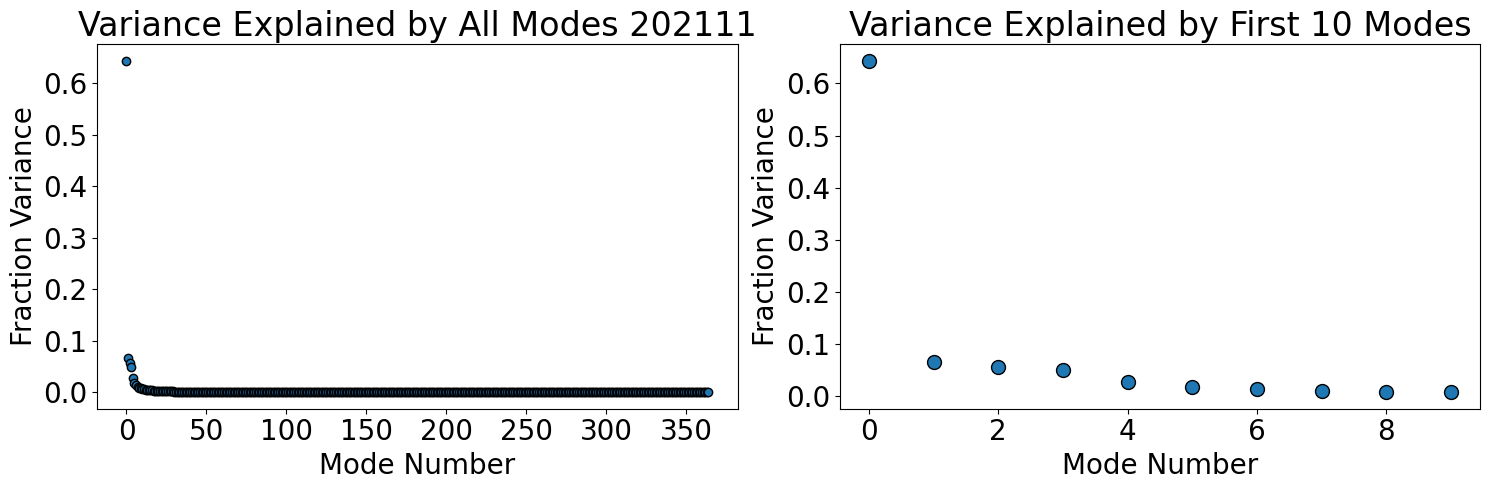

In [9]:
pca_params_201905 = do_pca(phys_arr_201905,'201905')
pca_params_202111 = do_pca(phys_arr_202111,'202111')

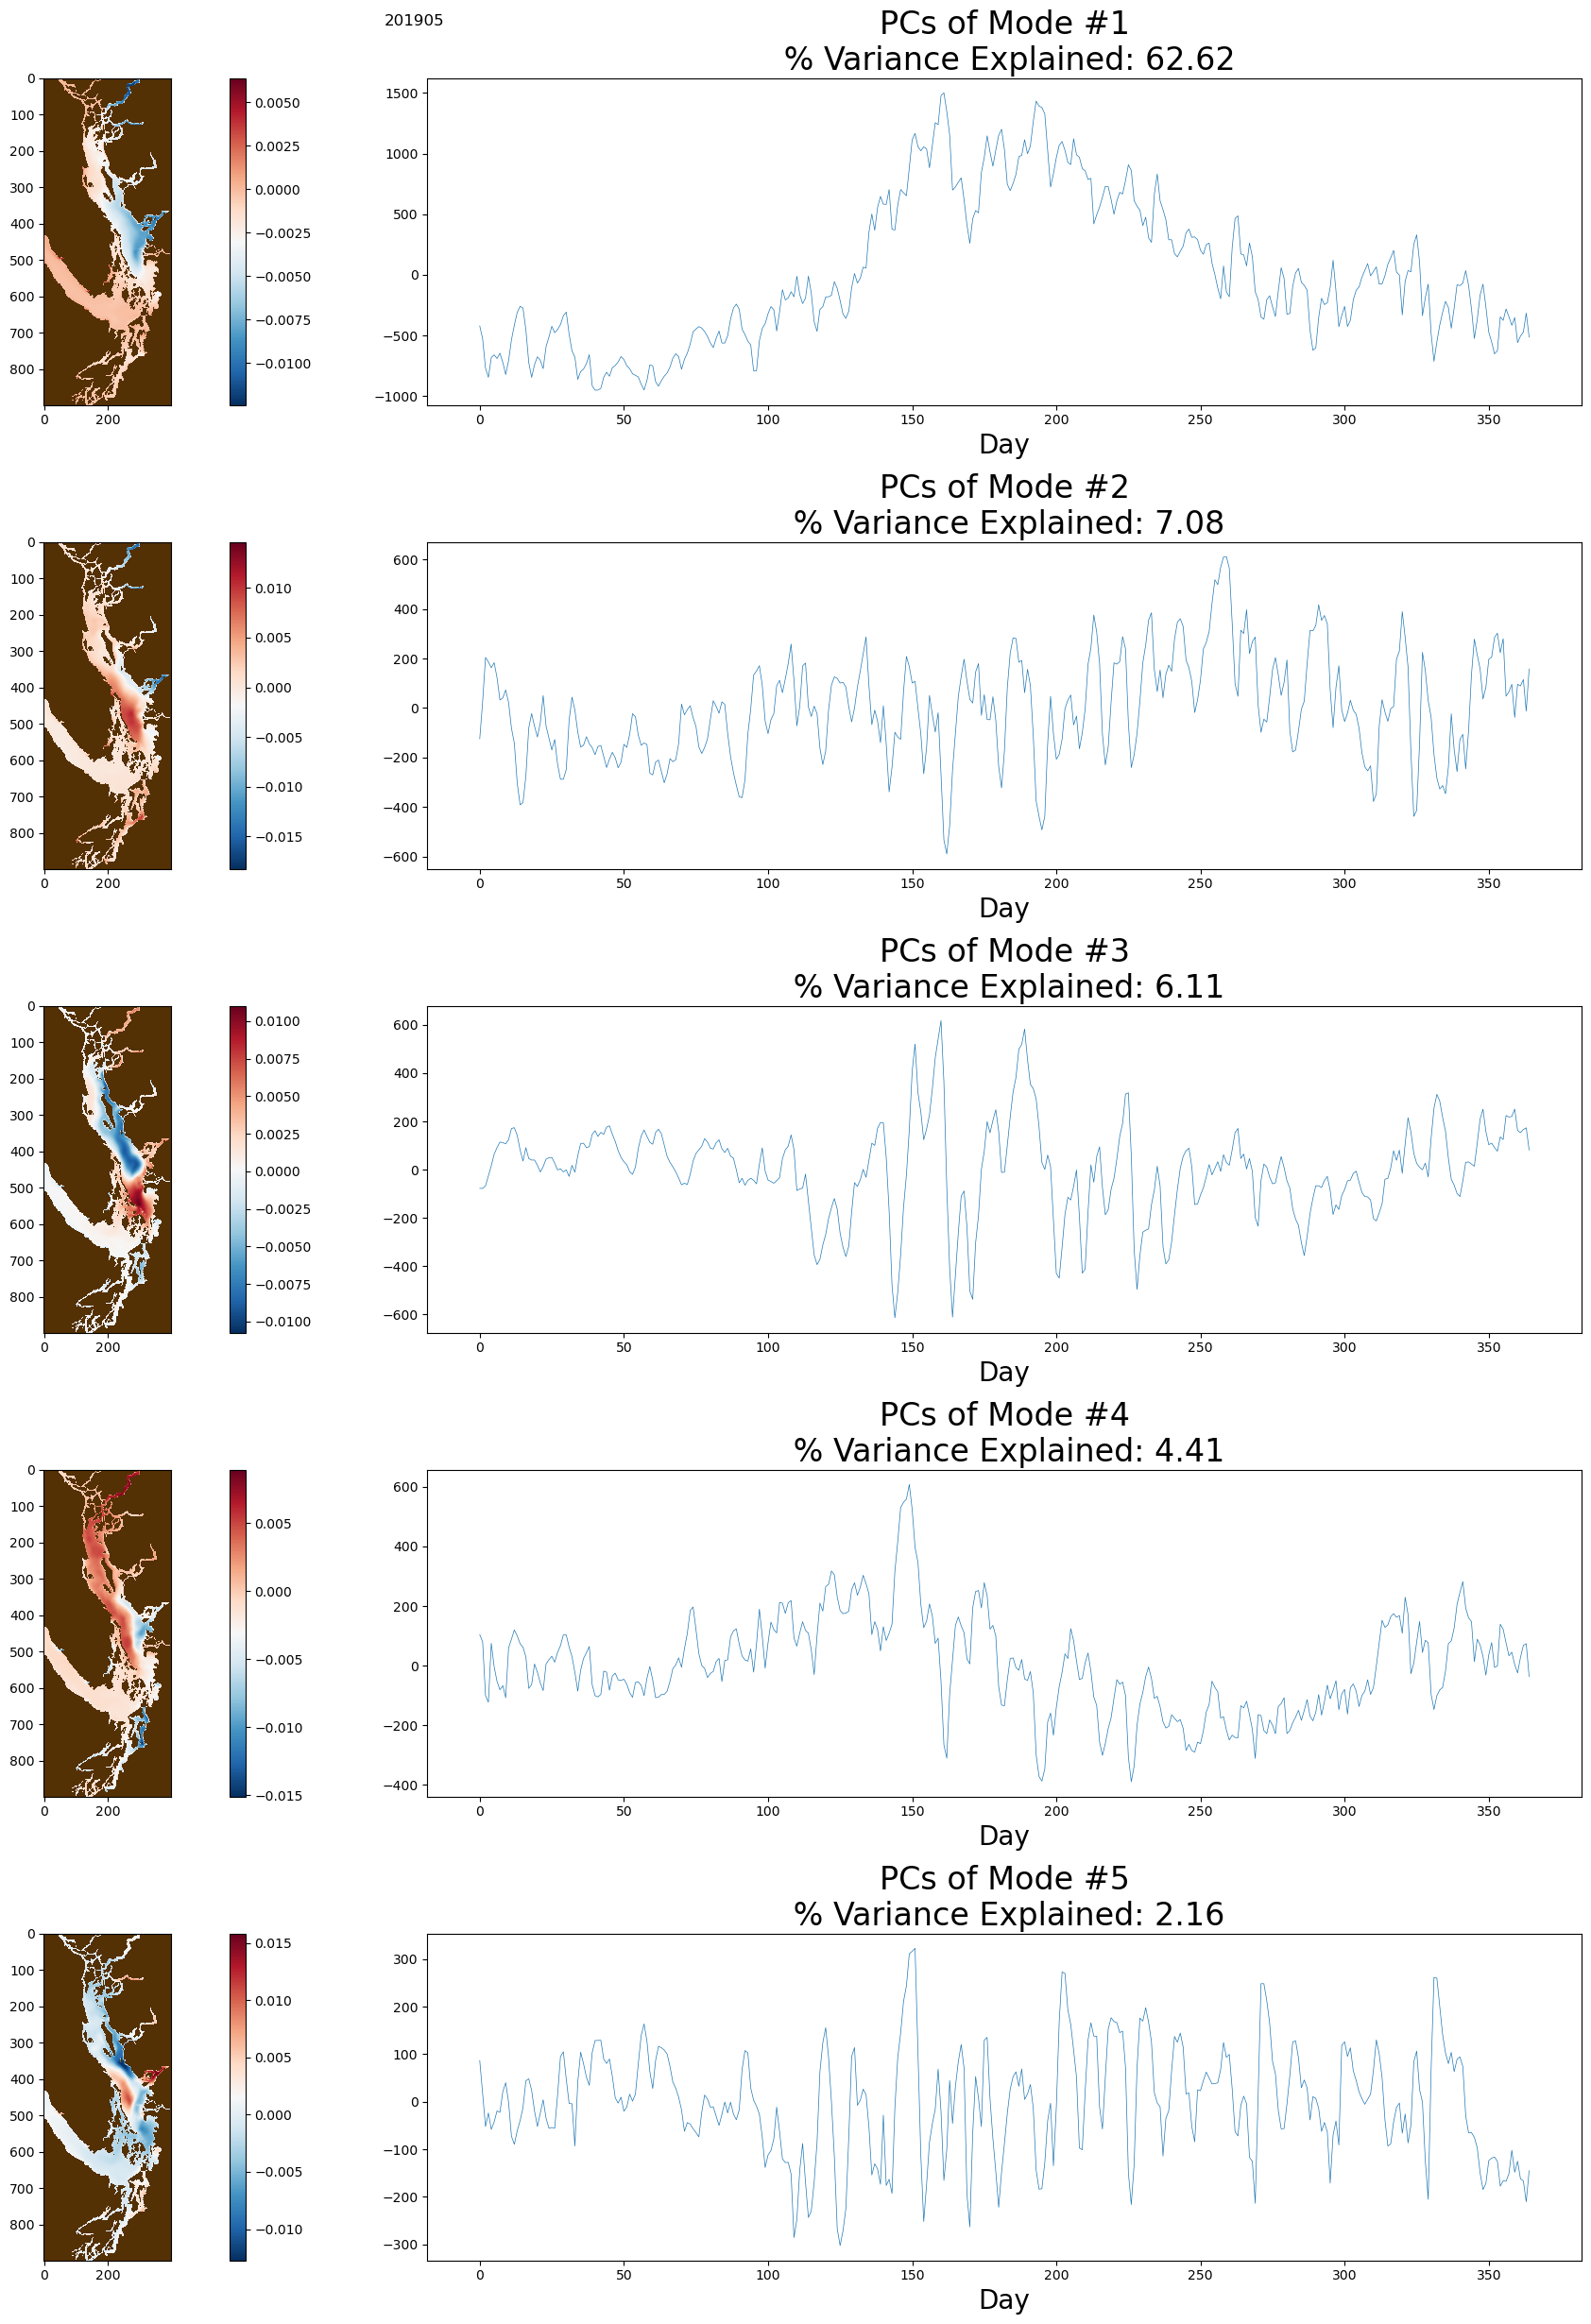

In [10]:
results_201905 = show_pca(*pca_params_201905,5,'201905')

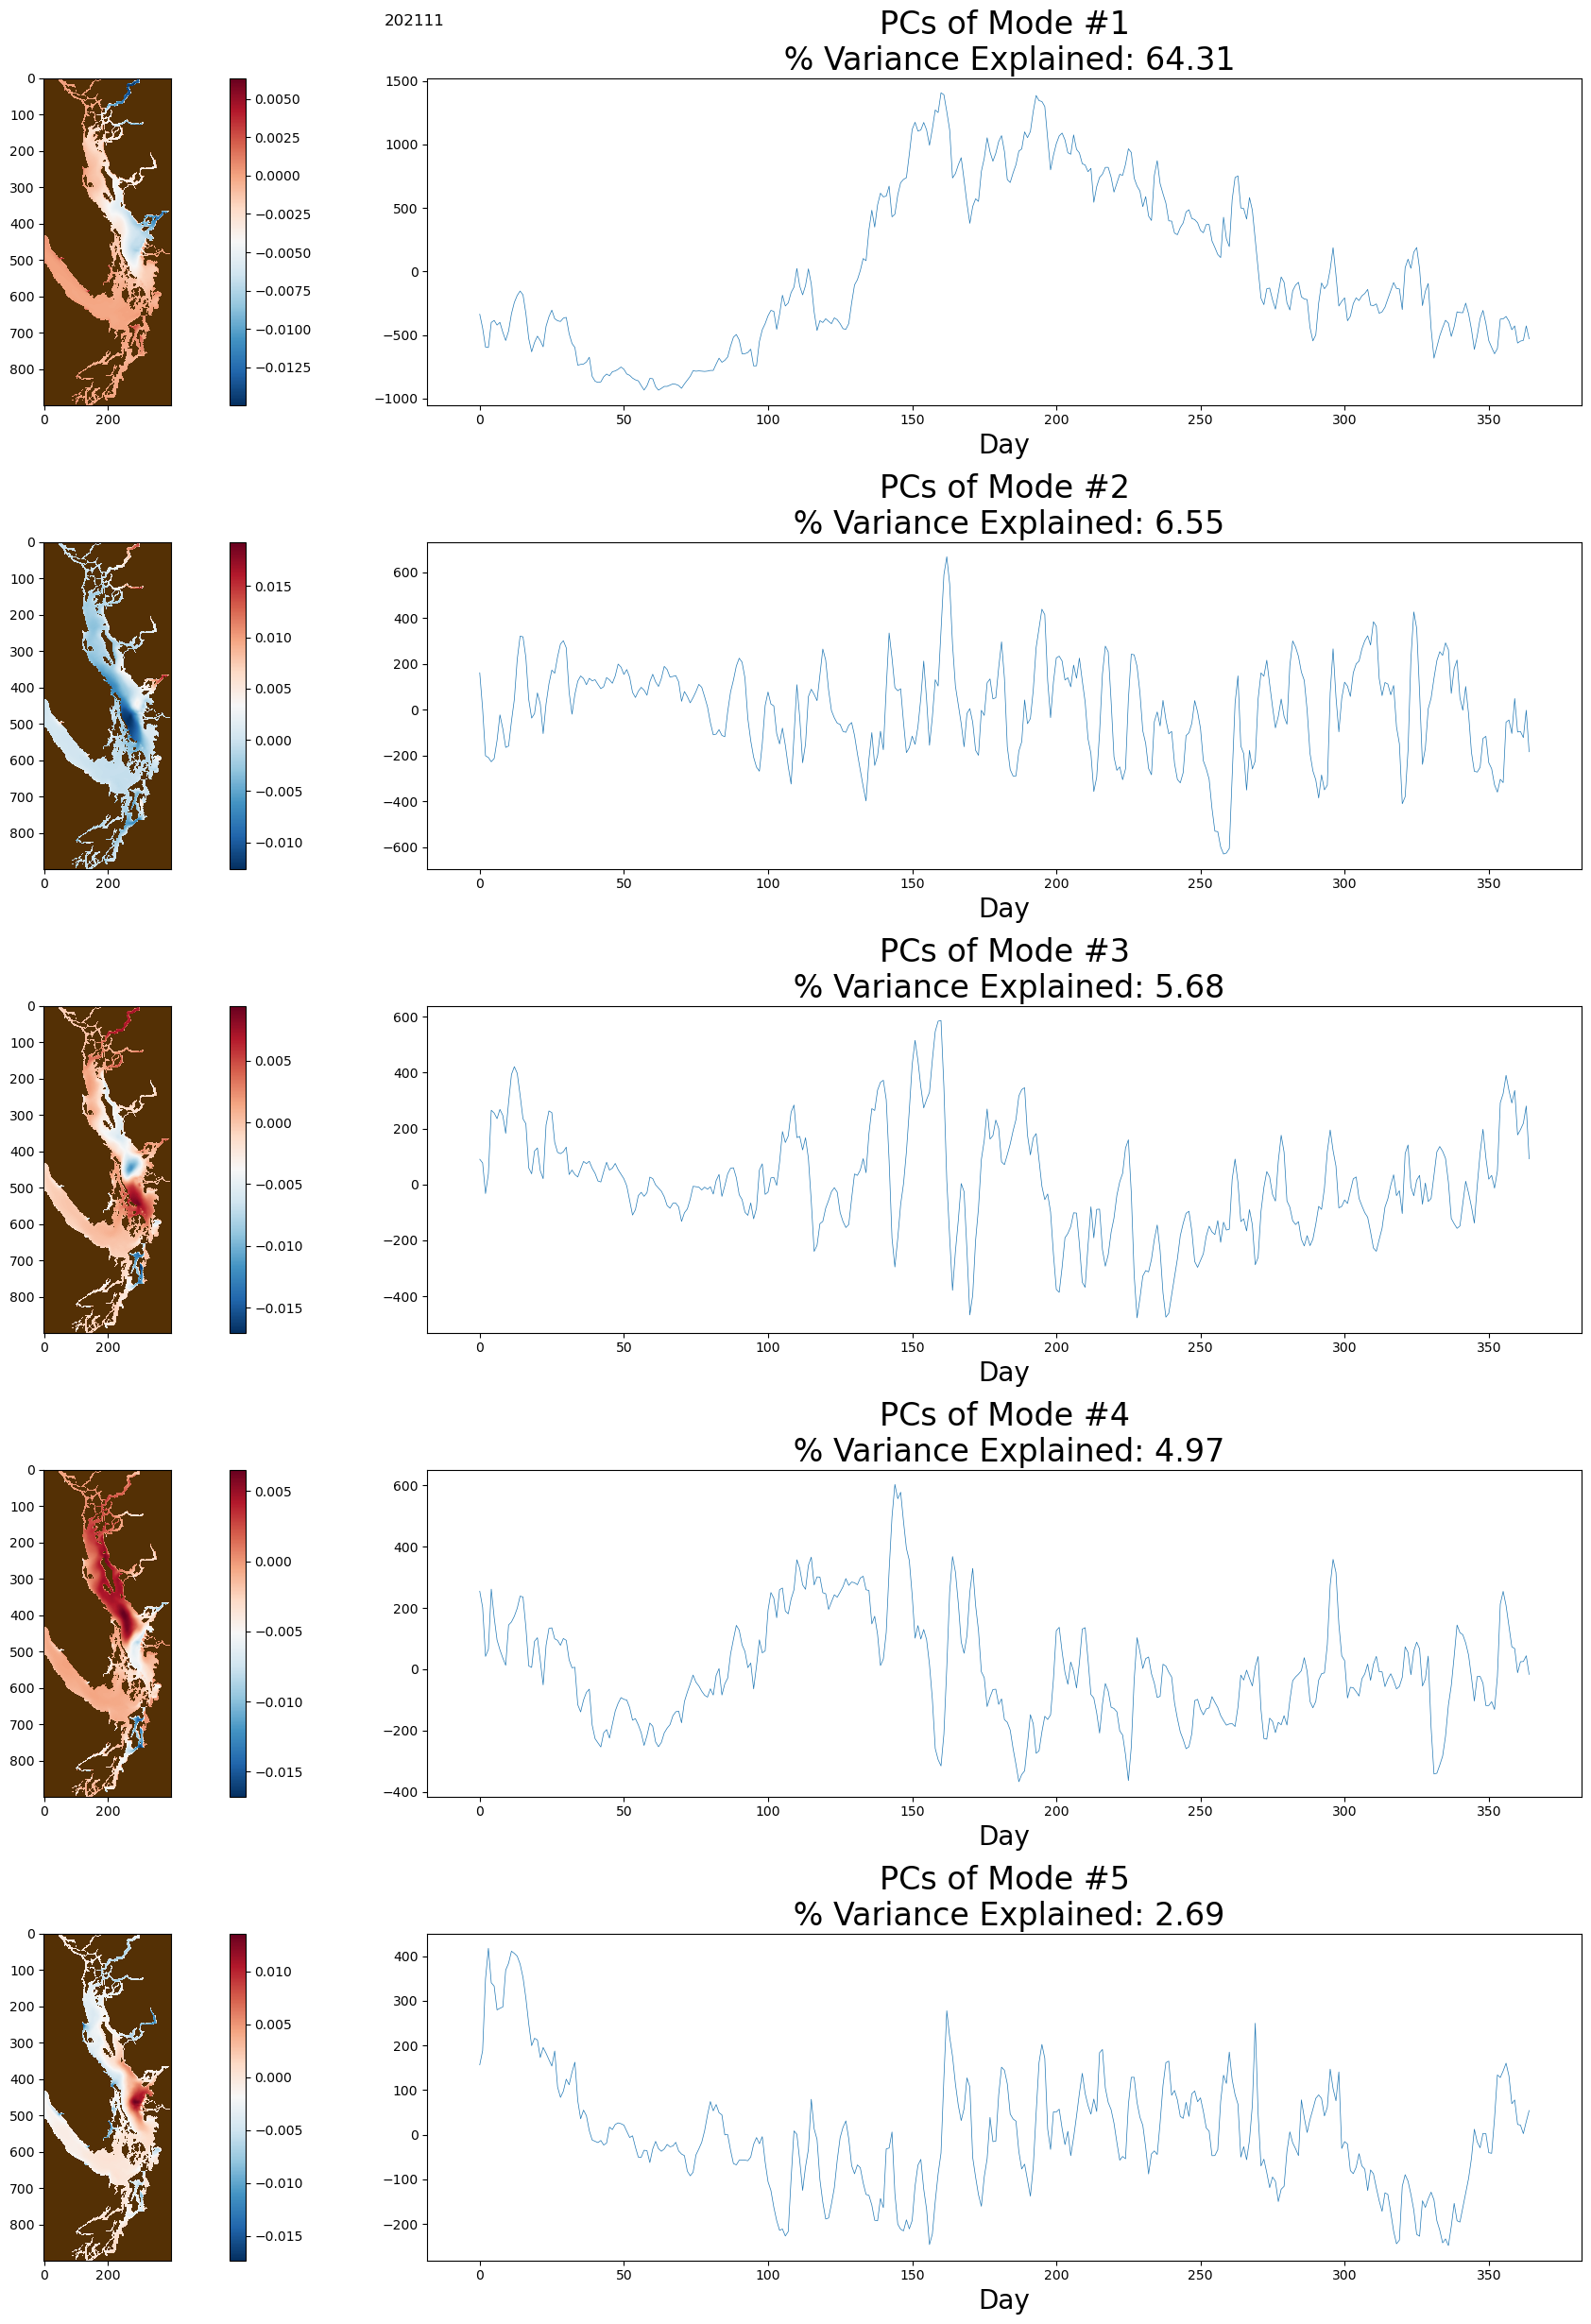

In [11]:
results_202111 = show_pca(*pca_params_202111,5,'202111')

In [48]:
# make a mask of land where land is true and water in NaN
# bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_202108.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

# open the mesh mask and use it to mask the land
# mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

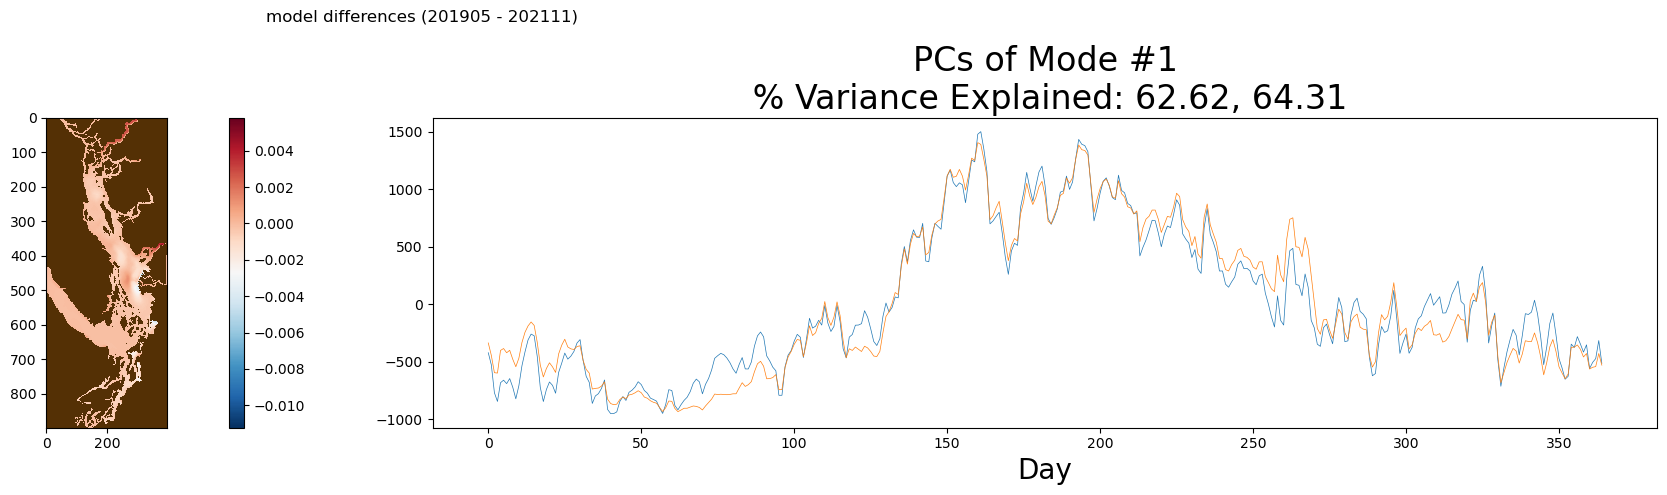

In [49]:
Nx = pca_params_201905[2]
Ny = pca_params_201905[3]

fracVar_201905 = results_201905[0]
eigvecs_201905 = results_201905[1]
PCs_201905 = results_201905[2]

fracVar_202111 = results_202111[0]
eigvecs_202111 = results_202111[1]
PCs_202111 = results_202111[2]

eigvecs_diff = eigvecs_201905 - eigvecs_202111


#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
fig2, ax2 = plt.subplots(1, 2, figsize=(25, 5))
plt.suptitle('model differences (201905 - 202111)')

# plt.subplot(1,2)
to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs_diff[0],(Nx,Ny))), mask=tmask[0])
cb = ax2[0].imshow(np.flipud(np.reshape(eigvecs_diff[0],(Nx,Ny))), cmap='RdBu_r')
plt.colorbar(cb)
cb2 = ax2[0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
viz_tools.set_aspect(ax2[0]);


ax2[1].plot(PCs_201905[:,0], linewidth = 0.5)
ax2[1].plot(PCs_202111[:,0], linewidth = 0.5)
ax2[1].set_title('PCs of Mode #' + str(1) + "\n % Variance Explained: " + str(round(100*fracVar_201905[0],2)) + ", " + str(round(100*fracVar_202111[0],2)), fontsize = 24)
ax2[1].set_xlabel('Day', fontsize = 20)
    
plt.tight_layout()

# plt.savefig('2020_modes.png')
plt.show()

Text(0.5, 0, 'Day')

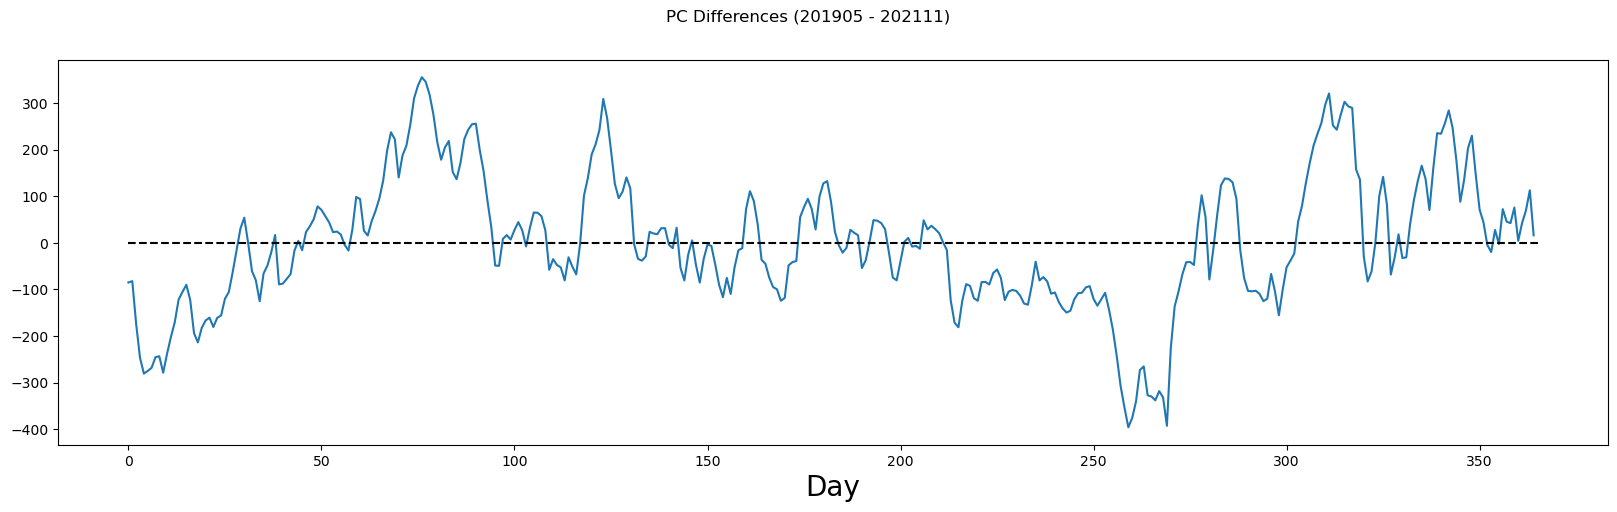

In [50]:
fig3, ax3 = plt.subplots(1, 1, figsize=(20, 5))
plt.suptitle('PC Differences (201905 - 202111)')

ax3.plot(PCs_201905[:,0]-PCs_202111[:,0], linewidth = 1.5)
ax3.hlines(0,0,len(PCs_201905[:,0]),'k',linestyles='--')
ax3.set_xlabel('Day', fontsize = 20)

# Make Timeseries

In [15]:
rivers.prop_dict['puget']['NisquallyMcAllister']['j']

135

In [16]:
runoff = xr.open_dataset('../../../../../../results/forcing/rivers/R201702DFraCElse_y2023m01d19.nc')

In [17]:
i_riv = 1
j_riv = 135

eigvecs_202111[0].shape
np.flipud(np.reshape(eigvecs_202111[0],(Nx,Ny))).shape
np.flipud(np.reshape(eigvecs_202111[0],(Nx,Ny)))[Nx-i_riv, j_riv]
np.mean(np.flipud(np.reshape(eigvecs_202111[0],(Nx,Ny))))

-0.00047126823

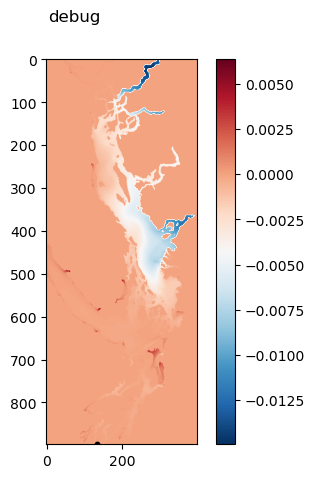

In [18]:
fig3, ax3 = plt.subplots(1, 1, figsize=(5, 5))
plt.suptitle('debug')

to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs_202111[0],(Nx,Ny))), mask=tmask[0])
cb = ax3.imshow(np.flipud(np.reshape(eigvecs_202111[0],(Nx,Ny))), cmap='RdBu_r')
plt.colorbar(cb)
# cb2 = ax3.pcolormesh(np.flipud(land), cmap='BrBG')  ################## want

ax3.scatter(j_riv, Nx-i_riv, s=10, color='k',alpha=1)
viz_tools.set_aspect(ax3);

In [19]:
## DO PCA PART 202111
surface = phys_arr_202111[:,0,:,:].reshape(365, 357404)  # TODO: FIX THIS to not hard coded
surface = np.nan_to_num(surface)


pca = PCA(n_components=1)
PCs = pca.fit_transform(surface)
surface_rec = pca.inverse_transform(PCs)
surface_rec.shape

(365, 357404)

In [20]:
## DO PCA PART 201905
surface_old = phys_arr_201905[:,0,:,:].reshape(365, 357404)  # TODO: FIX THIS to not hard coded
surface_old = np.nan_to_num(surface_old)


pca_old = PCA(n_components=1)
PCs = pca_old.fit_transform(surface_old)
surface_rec_old = pca_old.inverse_transform(PCs)
surface_rec_old.shape

(365, 357404)

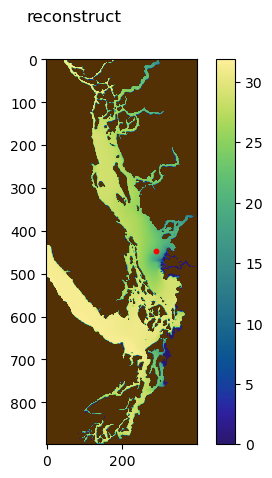

In [46]:
fig4, ax4 = plt.subplots(1, 1, figsize=(5, 5))
plt.suptitle('reconstruct')

to_show = np.ma.masked_array(np.flipud(np.reshape(surface_rec[0],(Nx,Ny))), mask=tmask[0])
cb = ax4.imshow(np.flipud(np.reshape(surface_rec[0],(Nx,Ny))), cmap=cm.haline)
plt.colorbar(cb)
cb2 = ax4.pcolormesh(np.flipud(land), cmap='BrBG')  ################## want

ax4.scatter(290, Nx-450-1, s=10, color='r',alpha=1)
viz_tools.set_aspect(ax4);

In [28]:
## write a function to do the looping?

def var_timeseries(w_shed, r_name, var_field):
    var_list = []

    for i in np.arange(len(var_field)):
        varf_day = np.flipud(np.reshape(var_field[i],(Nx,Ny)))

        var_list = var_list + [varf_day[Nx-rivers.prop_dict[w_shed][r_name]['i'], rivers.prop_dict[w_shed][r_name]['j']]]

    return np.asarray(var_list)

In [35]:
# get salinity timeseries for 202111 rivers
Nisqually_sal = var_timeseries('puget','NisquallyMcAllister',surface_rec)
Squamish_sal = var_timeseries('howe','Squamish',surface_rec)
Homathko_sal = var_timeseries('bute','Homathko',surface_rec)
Elwha_sal = var_timeseries('jdf','Elwha',surface_rec)


In [43]:
# get salinity timeseries for 202111 other points
mid_strait_sal  = []

for i in np.arange(len(surface_rec)):
    surf_rec = np.flipud(np.reshape(surface_rec[i],(Nx,Ny)))

    mid_strait_sal = mid_strait_sal + [surf_rec[Nx-450, 290]]

mid_strait_sal = np.asarray(mid_strait_sal)

In [37]:
# get salinity timeseries for 201905 rivers
Nisqually_sal_old = var_timeseries('puget','NisquallyMcAllister',surface_rec_old)
Squamish_sal_old = var_timeseries('howe','Squamish',surface_rec_old)
Homathko_sal_old = var_timeseries('bute','Homathko',surface_rec_old)
Elwha_sal_old = var_timeseries('jdf','Elwha',surface_rec_old)

In [44]:
# get salinity timeseries for 201905 other points
mid_strait_sal_old  = []

for i in np.arange(len(surface_rec_old)):
    surf_rec = np.flipud(np.reshape(surface_rec_old[i],(Nx,Ny)))

    mid_strait_sal_old = mid_strait_sal_old + [surf_rec[Nx-450, 290]]

mid_strait_sal_old = np.asarray(mid_strait_sal_old)

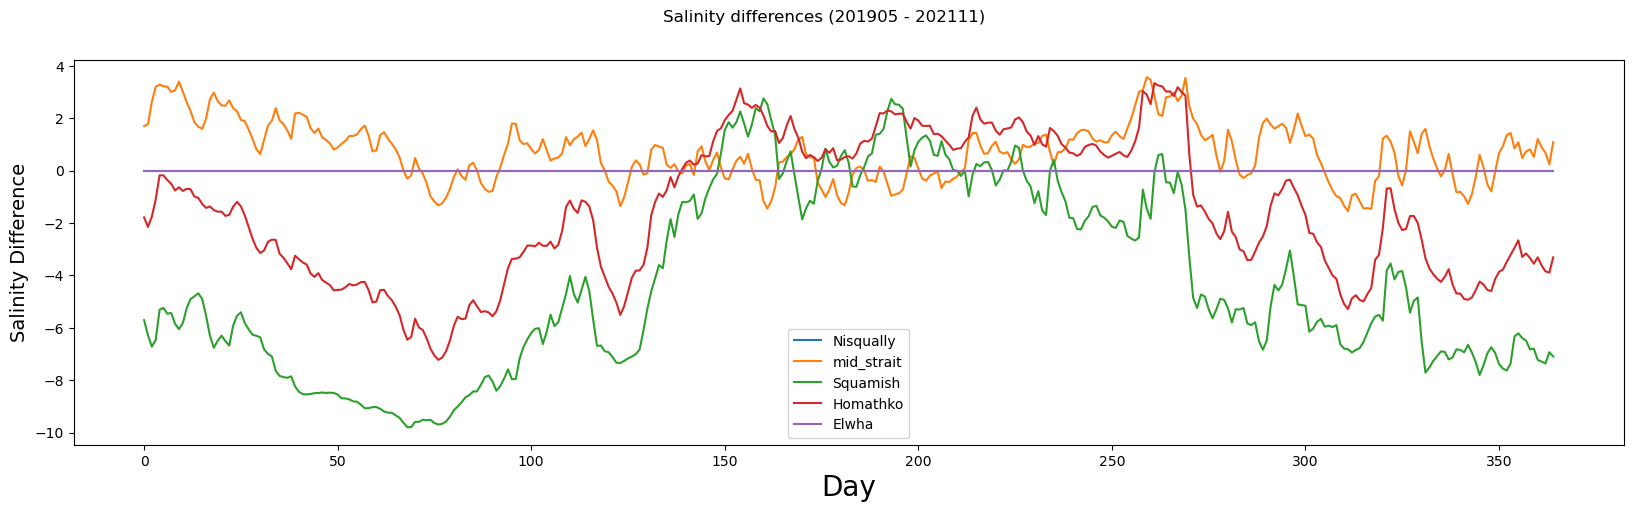

In [45]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20, 5))
plt.suptitle('Salinity differences (201905 - 202111)')

ax5.plot(Nisqually_sal_old-Nisqually_sal, linewidth = 1.5,label='Nisqually')
ax5.plot(mid_strait_sal_old-mid_strait_sal, linewidth = 1.5,label='mid_strait')
ax5.plot(Squamish_sal_old-Squamish_sal, linewidth = 1.5,label='Squamish')
ax5.plot(Homathko_sal_old-Homathko_sal, linewidth = 1.5,label='Homathko')
ax5.plot(Elwha_sal_old-Elwha_sal, linewidth = 1.5,label='Elwha')
ax5.set_xlabel('Day', fontsize = 20)
ax5.set_ylabel('Salinity Difference', fontsize = 14)
ax5.legend()

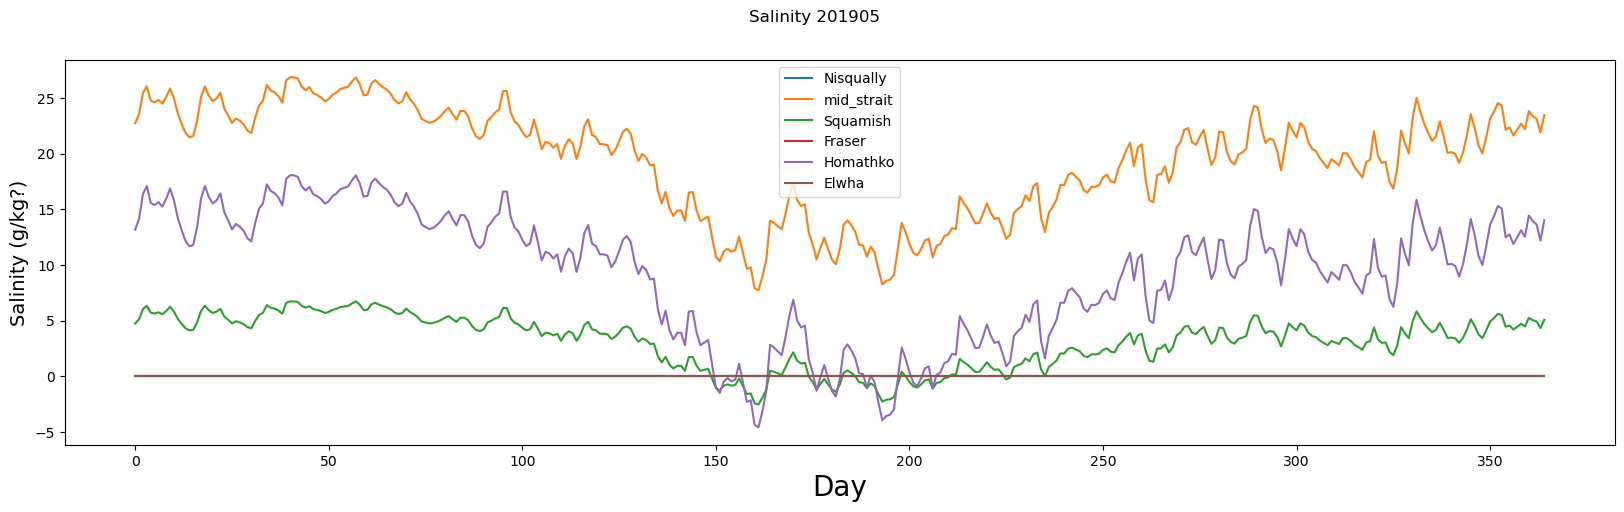

In [40]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20, 5))
plt.suptitle('Salinity 201905')

ax5.plot(Nisqually_sal_old, linewidth = 1.5,label='Nisqually')
ax5.plot(mid_strait_sal_old, linewidth = 1.5,label='mid_strait')
ax5.plot(Squamish_sal_old, linewidth = 1.5,label='Squamish')
ax5.plot(Homathko_sal_old, linewidth = 1.5,label='Homathko')
ax5.plot(Elwha_sal_old, linewidth = 1.5,label='Elwha')
ax5.set_xlabel('Day', fontsize = 20)
ax5.set_ylabel('Salinity (g/kg?)', fontsize = 14)
ax5.legend()

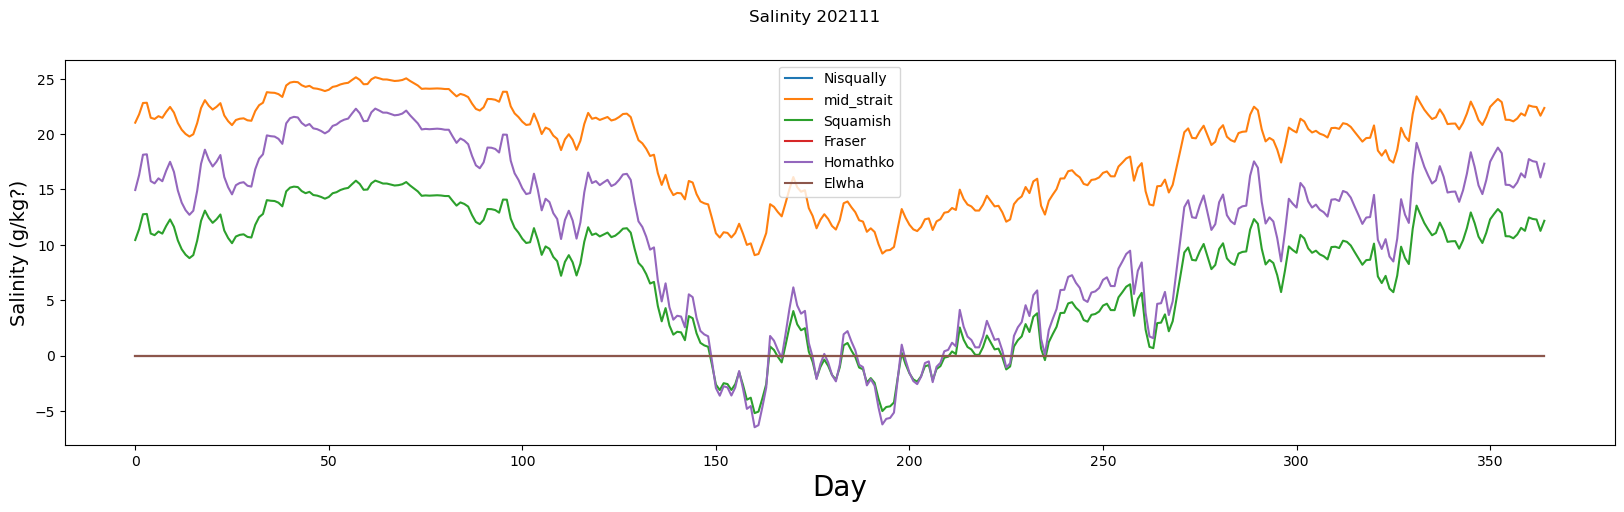

In [41]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20, 5))
plt.suptitle('Salinity 202111')

ax5.plot(Nisqually_sal, linewidth = 1.5,label='Nisqually')
ax5.plot(mid_strait_sal, linewidth = 1.5,label='mid_strait')
ax5.plot(Squamish_sal, linewidth = 1.5,label='Squamish')
ax5.plot(Fraser_sal, linewidth = 1.5,label='Fraser')
ax5.plot(Homathko_sal, linewidth = 1.5,label='Homathko')
ax5.plot(Elwha_sal, linewidth = 1.5,label='Elwha')
# ax5.hlines(0,0,len(PCs_201905[:,0]),'k',linestyles='--')
ax5.set_xlabel('Day', fontsize = 20)
ax5.set_ylabel('Salinity (g/kg?)', fontsize = 14)
ax5.legend()

Text(144, 261, 'Elwha')

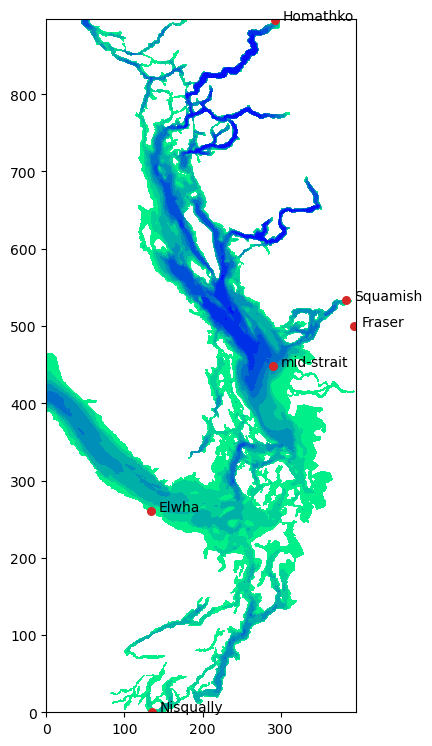

In [27]:
imin, imax = 0, 898
jmin, jmax = 0, 398
jj = range(jmax)
ii = range(imax)
jjm, iim = np.meshgrid(jj, ii)
fluxarray = np.array(runoff.rorunoff[0, :, :jmax])
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.contourf(bathymetry.Bathymetry[:, :jmax], cmap='winter_r')
      
# ax.scatter(jjm[fluxarray>0], iim[fluxarray>0], s=fluxarray[fluxarray>0]*1000, color='tab:red',alpha=0.5)
ax.scatter(rivers.prop_dict['puget']['NisquallyMcAllister']['j'], rivers.prop_dict['puget']['NisquallyMcAllister']['i'], s=30, color='tab:red',alpha=1,label='Nisqually')
ax.text(rivers.prop_dict['puget']['NisquallyMcAllister']['j']+10, rivers.prop_dict['puget']['NisquallyMcAllister']['i'],'Nisqually')

ax.scatter(rivers.prop_dict['howe']['Squamish']['j'], rivers.prop_dict['howe']['Squamish']['i'], s=30, color='tab:red',alpha=1,label='Squamish')
ax.text(rivers.prop_dict['howe']['Squamish']['j']+10, rivers.prop_dict['howe']['Squamish']['i'],'Squamish')

ax.scatter(rivers.prop_dict['fraser']['Fraser']['j'], rivers.prop_dict['fraser']['Fraser']['i'], s=30, color='tab:red',alpha=1,label='Fraser')
ax.text(rivers.prop_dict['fraser']['Fraser']['j']+10, rivers.prop_dict['fraser']['Fraser']['i'],'Fraser')

ax.scatter(290, Nx-450, s=30, color='tab:red',alpha=1,label='Fraser')
ax.text(290+10, Nx-450,'mid-strait')

ax.scatter(rivers.prop_dict['bute']['Homathko']['j'], rivers.prop_dict['bute']['Homathko']['i'], s=30, color='tab:red',alpha=1,label='Homathko')
ax.text(rivers.prop_dict['bute']['Homathko']['j']+10, rivers.prop_dict['bute']['Homathko']['i'],'Homathko')

ax.scatter(rivers.prop_dict['jdf']['Elwha']['j'], rivers.prop_dict['jdf']['Elwha']['i'], s=30, color='tab:red',alpha=1,label='Elwha')
ax.text(rivers.prop_dict['jdf']['Elwha']['j']+10, rivers.prop_dict['jdf']['Elwha']['i'],'Elwha')